In [1]:
from itertools import takewhile
from operator import itemgetter

from sec_certs.dataset.fips_mip import MIPDataset
from sec_certs.dataset.fips_iut import IUTDataset
from sec_certs.sample.fips_mip import MIPStatus
from sec_certs.model.fips_matching import FIPSProcessMatcher
from sec_certs.dataset.fips import FIPSDataset
from sec_certs.configuration import config
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import matplotlib.ticker as mtick
import warnings

plt.style.use("seaborn-whitegrid")
sns.set_palette("deep")
sns.set_context("notebook") # Set to "paper" for use in paper :)

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
fips = FIPSDataset.from_web_latest()


## IUT dataset

In [3]:
iut_dset = IUTDataset.from_web_latest()

In [9]:
iut_global_df = pd.DataFrame(iut_dset.snapshots, columns=["timestamp", "displayed", "not_displayed", "total"])
iut_global_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844 entries, 0 to 843
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      844 non-null    datetime64[ns]
 1   displayed      838 non-null    float64       
 2   not_displayed  838 non-null    float64       
 3   total          838 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 26.5 KB


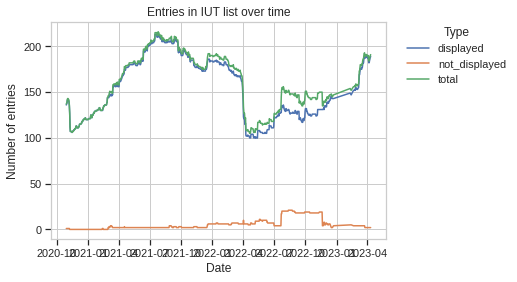

In [10]:
iut_melt = iut_global_df.melt("timestamp", var_name="type", value_name="count")
line = sns.lineplot(data=iut_melt, x="timestamp", y="count", hue="type")
line.set(xlabel="Date", ylabel="Number of entries", title="Entries in IUT list over time")
line.legend(title="Type", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [11]:
s0 = iut_dset.snapshots[0]
print(s0.__dict__.keys())
print(next(iter(s0.entries)))

dict_keys(['entries', 'timestamp', 'last_updated', 'displayed', 'not_displayed', 'total'])
IUTEntry(module_name='ProtectServer PCIe HSM 3', vendor_name='Thales', standard='FIPS 140-3', iut_date=datetime.date(2022, 7, 15))


In [9]:
def iut_key(entry):
    return entry.module_name, entry.vendor_name, entry.standard

iut_first_seen = {}
iut_last_seen = {}
for snapshot in tqdm(sorted(iut_dset.snapshots, key=lambda x: x.timestamp)):
    snapshot_date = snapshot.timestamp.date()
    for entry in snapshot.entries:
        entry_key = entry # iut_key(entry) # or entry here
        if entry_key not in iut_first_seen:
            iut_first_seen[entry_key] = snapshot_date
        if entry_key not in iut_last_seen or iut_last_seen[entry_key] < snapshot_date:
            iut_last_seen[entry_key] = snapshot_date

#iut_local_df = pd.DataFrame([(entry[0], entry[1], entry[2], iut_first_seen[entry], iut_last_seen[entry], iut_last_seen[entry] == snapshot_date) for entry in iut_first_seen.keys()], columns=("name", "vendor", "standard", "first_seen", "last_seen", "present"))
iut_local_df = pd.DataFrame([(entry.module_name, entry.vendor_name, entry.standard, entry.iut_date, iut_first_seen[entry], iut_last_seen[entry], iut_last_seen[entry] == snapshot_date) for entry in iut_first_seen.keys()], columns=("name", "vendor", "standard", "iut_date", "first_seen", "last_seen", "present"))
iut_local_df = iut_local_df.astype({"standard": "category", "iut_date": "datetime64", "first_seen": "datetime64", "last_seen": "datetime64", "present": "bool"}).fillna(value=np.nan)
iut_local_df["seen_for_iut"] = (iut_local_df.last_seen - iut_local_df.iut_date).dt.days
iut_local_df["seen_for"] = (iut_local_df.last_seen - iut_local_df.first_seen).dt.days

print("All:")
print("Average seen for", np.mean(iut_local_df.seen_for))
print("Average seen for (FIPS 140-2)", np.mean(iut_local_df.loc[iut_local_df.standard == "FIPS 140-2"].seen_for))
print("Average seen for (FIPS 140-3)", np.mean(iut_local_df.loc[iut_local_df.standard == "FIPS 140-3"].seen_for))
print("Average seen for[iut]", np.mean(iut_local_df.seen_for_iut))
print("Average seen for[iut] (FIPS 140-2)", np.mean(iut_local_df.loc[iut_local_df.standard == "FIPS 140-2"].seen_for_iut))
print("Average seen for[iut] (FIPS 140-3)", np.mean(iut_local_df.loc[iut_local_df.standard == "FIPS 140-3"].seen_for_iut))

print("Only not present:")
print("Average seen for", np.mean(iut_local_df.loc[~iut_local_df.present].seen_for))
print("Average seen for (FIPS 140-2)", np.mean(iut_local_df.loc[(iut_local_df.standard == "FIPS 140-2") & ~iut_local_df.present].seen_for))
print("Average seen for (FIPS 140-3)", np.mean(iut_local_df.loc[(iut_local_df.standard == "FIPS 140-3") & ~iut_local_df.present].seen_for))
print("Average seen for[iut]", np.mean(iut_local_df.loc[~iut_local_df.present].seen_for_iut))
print("Average seen for[iut] (FIPS 140-2)", np.mean(iut_local_df.loc[(iut_local_df.standard == "FIPS 140-2") & ~iut_local_df.present].seen_for_iut))
print("Average seen for[iut] (FIPS 140-3)", np.mean(iut_local_df.loc[(iut_local_df.standard == "FIPS 140-3") & ~iut_local_df.present].seen_for_iut))


100%|██████████| 844/844 [00:00<00:00, 2583.44it/s]

All:
Average seen for 186.7893296853625
Average seen for (FIPS 140-2) 164.91643454039
Average seen for (FIPS 140-3) 207.8978494623656
Average seen for[iut] 232.2325581395349
Average seen for[iut] (FIPS 140-2) 239.0557103064067
Average seen for[iut] (FIPS 140-3) 225.6478494623656
Only not present:
Average seen for 195.63653136531366
Average seen for (FIPS 140-2) 170.39420289855073
Average seen for (FIPS 140-3) 239.84263959390864
Average seen for[iut] 251.76752767527674
Average seen for[iut] (FIPS 140-2) 246.34782608695653
Average seen for[iut] (FIPS 140-3) 261.25888324873097


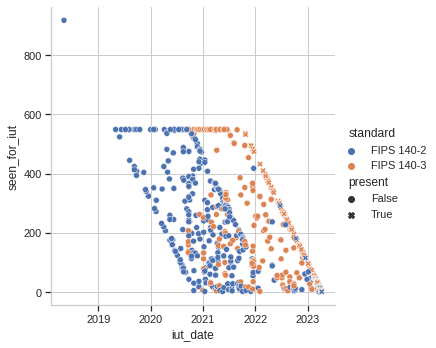

In [10]:
scatter = sns.relplot(kind="scatter", data=iut_local_df, x="iut_date", y="seen_for_iut", hue="standard", style="present", aspect=1)

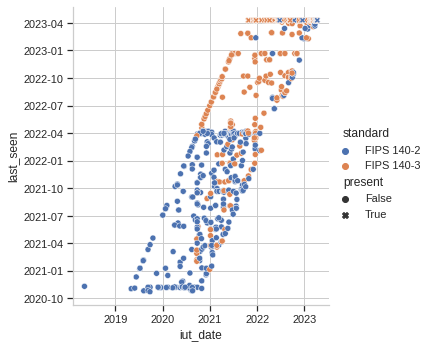

In [11]:
scatter = sns.relplot(kind="scatter", data=iut_local_df, x="iut_date", y="last_seen", hue="standard", style="present", aspect=1)

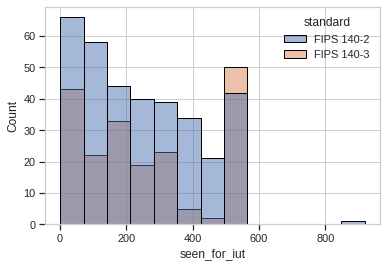

In [12]:
hist = sns.histplot(data=iut_local_df[~iut_local_df.present], x="seen_for_iut", hue="standard")

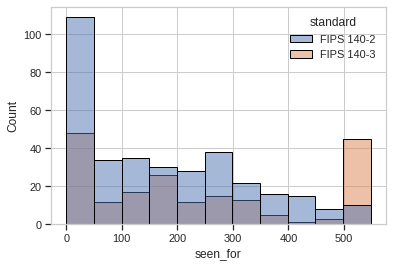

In [13]:
hist = sns.histplot(data=iut_local_df[~iut_local_df.present], x="seen_for", hue="standard")

In [14]:
iut_local_df.vendor.value_counts()

Cisco Systems, Inc.                                 35
Juniper Networks, Inc.                              30
Fortinet, Inc.                                      27
Apple Inc.                                          26
Oracle Corporation                                  23
                                                    ..
Ampex Data Systems Corporation                       1
Communication Devices, Inc.                          1
Hitachi, Ltd.                                        1
SafeLogic                                            1
Toshiba Electronic Devices & Storage Corporation     1
Name: vendor, Length: 254, dtype: int64

### IUT - Certificate mapping

In [9]:
first_snapshot = iut_dset.snapshots[-1]

matches = {}
for entry in first_snapshot:
    matcher = FIPSProcessMatcher(entry)
    scores = sorted(((matcher.match(cert), cert) for cert in fips), key=itemgetter(0), reverse=True)
    print(entry)
    found = False
    for score, cert in scores:
        if score < config.fips_matching_threshold:
            break
        validations = cert.web_data.validation_history
        for validation in validations:
            if validation.date >= first_snapshot.timestamp.date():
                # It could be this cert, so take it
                found = True
                matches[entry] = cert
                break
        if found:
            break
    if found:
        print(matches[entry].name)
    else:
        print("**")
    print("-------------------------")

IUTEntry(module_name='Capri 1.0', vendor_name='Pensando Systems, Inc', standard='FIPS 140-2', iut_date=datetime.date(2019, 10, 18))
**
-------------------------
IUTEntry(module_name='SafeNet Luna Backup HSM Cryptographic Module', vendor_name='Gemalto, a Thales Company', standard='FIPS 140-2', iut_date=datetime.date(2020, 1, 29))
Thales Luna Backup HSM Cryptographic Module
-------------------------
IUTEntry(module_name='Juniper Networks EX4650, QFX5120, QFX5200 and QFX5210 Ethernet Switches', vendor_name='Juniper Networks', standard='FIPS 140-2', iut_date=datetime.date(2020, 9, 25))
Juniper Networks EX4650, QFX5120 and QFX5210 Ethernet Switches
-------------------------
IUTEntry(module_name='Intel(R) Converged Security Engine for Tiger Lake, Rocket Lake, and Elkhart Lake', vendor_name='Intel Corporation', standard='FIPS 140-2', iut_date=datetime.date(2020, 5, 27))
Intel® Converged Security and Manageability Engine (CSME) Crypto Module for Tiger Point PCH, Mule Creek Canyon PCH, and Rock

## MIP dataset

In [15]:
mip_dset = MIPDataset.from_web_latest()

In [16]:
mip_global_df = pd.DataFrame(mip_dset.snapshots, columns=["timestamp", "displayed", "not_displayed", "total"])
mip_global_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844 entries, 0 to 843
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      844 non-null    datetime64[ns]
 1   displayed      844 non-null    int64         
 2   not_displayed  844 non-null    int64         
 3   total          844 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 26.5 KB


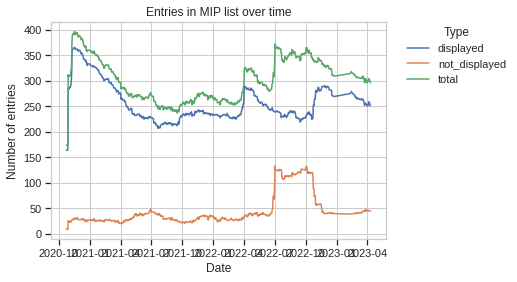

In [17]:
mip_melt = mip_global_df.melt("timestamp", var_name="type", value_name="count")
line = sns.lineplot(data=mip_melt, x="timestamp", y="count", hue="type")
line.set(xlabel="Date", ylabel="Number of entries", title="Entries in MIP list over time")
line.legend(title="Type", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [18]:
m0 = mip_dset.snapshots[0]
print(m0.__dict__.keys())
print(next(iter(m0.entries)))

dict_keys(['entries', 'timestamp', 'last_updated', 'displayed', 'not_displayed', 'total'])
MIPEntry(module_name='Panorama 10.2 M-200, M-300, M-600 and M-700', vendor_name='Palo Alto Networks, Inc.', standard='FIPS 140-3', status=<MIPStatus.REVIEW_PENDING: 'Review Pending'>, status_since=datetime.date(2022, 12, 23))


In [19]:
def mip_key(entry):
    return entry.module_name, entry.vendor_name, entry.standard, entry.status

mip_first_seen = {}
mip_last_seen = {}
for snapshot in sorted(mip_dset.snapshots, key=lambda x: x.timestamp):
    snapshot_date = snapshot.timestamp.date()
    for entry in snapshot.entries:
        entry_key = entry # mip_key(entry) # or entry here
        if entry_key not in mip_first_seen:
            mip_first_seen[entry_key] = snapshot_date
        if entry_key not in mip_last_seen or mip_last_seen[entry_key] < snapshot_date:
            mip_last_seen[entry_key] = snapshot_date

#mip_local_df = pd.DataFrame([(entry[0], entry[1], entry[2], entry[3], mip_first_seen[entry], mip_last_seen[entry], mip_last_seen[entry] == snapshot_date) for entry in iut_first_seen.keys()], columns=("name", "vendor", "standard", "status", first_seen", "last_seen", "present"))
mip_local_df = pd.DataFrame([(entry.module_name, entry.vendor_name, entry.standard, entry.status, entry.status_since, mip_first_seen[entry], mip_last_seen[entry], mip_last_seen[entry] == snapshot_date) for entry in mip_first_seen.keys()], columns=("name", "vendor", "standard", "status", "status_since", "first_seen", "last_seen", "present"))
mip_local_df = mip_local_df.astype({"standard": "category", "status": "category", "status_since": "datetime64", "first_seen": "datetime64", "last_seen": "datetime64", "present": "bool"}).fillna(value=np.nan)
mip_local_df["seen_for_status"] = (mip_local_df.last_seen - mip_local_df.status_since).dt.days
mip_local_df["seen_for"] = (mip_local_df.last_seen - mip_local_df.first_seen).dt.days
mip_local_df.head()

,name,vendor,standard,status,status_since,first_seen,last_seen,present,seen_for_status,seen_for
0,"FireEye NX Series: NX1500, NX2500, NX2550, NX3...","FireEye, Inc.",FIPS 140-2,MIPStatus.IN_REVIEW,NaT,2020-10-22,2021-06-19,False,NaN,240
1,IBM(R) z/OS(R) Version 2 Release 4 ICSF PKCS #...,IBM Corporation,FIPS 140-2,MIPStatus.IN_REVIEW,NaT,2020-10-22,2021-03-11,False,NaN,140
2,Fortanix SDKMS Appliance,"Fortanix, Inc.",FIPS 140-2,MIPStatus.IN_REVIEW,NaT,2020-10-22,2021-04-07,False,NaN,167
3,IBM(R) z/OS(R) Version 2 Release 4 System SSL ...,IBM Corporation,FIPS 140-2,MIPStatus.IN_REVIEW,NaT,2020-10-22,2021-03-14,False,NaN,143
4,Vocera Smartbadge Cryptographic Module,"Vocera Communications, Inc.",FIPS 140-2,MIPStatus.IN_REVIEW,NaT,2020-10-22,2021-01-30,False,NaN,100


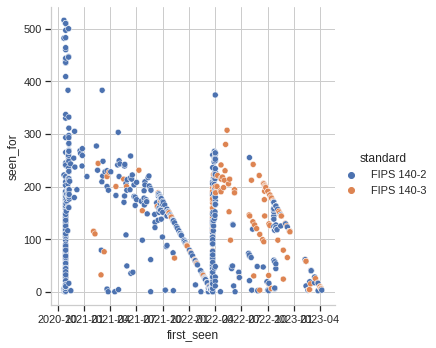

In [20]:
scatter = sns.relplot(kind="scatter", data=mip_local_df.loc[mip_local_df.status == MIPStatus.REVIEW_PENDING], x="first_seen", y="seen_for", hue="standard")

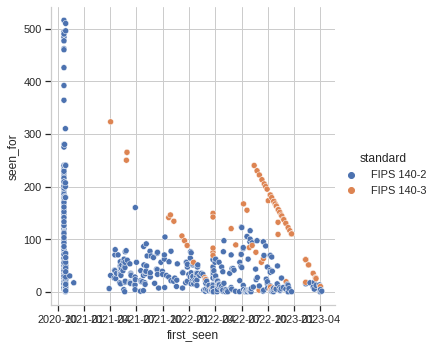

In [21]:
scatter = sns.relplot(kind="scatter", data=mip_local_df.loc[mip_local_df.status == MIPStatus.IN_REVIEW], x="first_seen", y="seen_for", hue="standard")

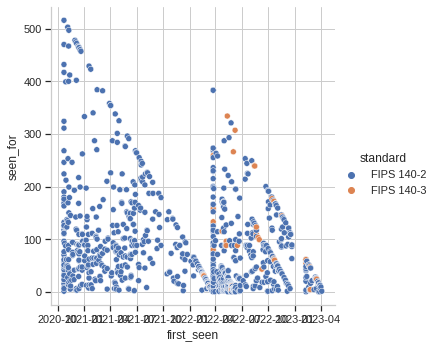

In [22]:
scatter = sns.relplot(kind="scatter", data=mip_local_df.loc[mip_local_df.status == MIPStatus.COORDINATION], x="first_seen", y="seen_for", hue="standard")

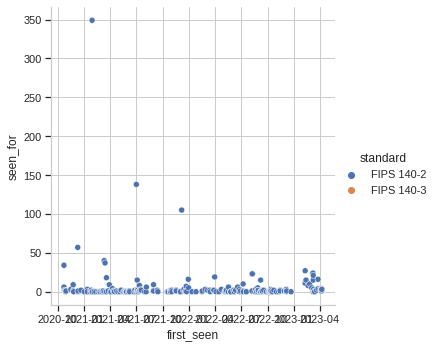

In [23]:
scatter = sns.relplot(kind="scatter", data=mip_local_df.loc[mip_local_df.status == MIPStatus.FINALIZATION], x="first_seen", y="seen_for", hue="standard")

In [24]:
for status in MIPStatus:
    print(status)
    print("All:")
    print("Average seen for", np.mean(mip_local_df.loc[mip_local_df.status == status].seen_for))
    print("Average seen for (FIPS 140-2)", np.mean(mip_local_df.loc[(mip_local_df.status == status) & (mip_local_df.standard == "FIPS 140-2")].seen_for))
    print("Average seen for (FIPS 140-3)", np.mean(mip_local_df.loc[(mip_local_df.status == status) & (mip_local_df.standard == "FIPS 140-3")].seen_for))
    
    print("Only not present:")
    print("Average seen for", np.mean(mip_local_df.loc[~(mip_local_df.present) & (mip_local_df.status == status)].seen_for))
    print("Average seen for (FIPS 140-2)", np.mean(mip_local_df.loc[~(mip_local_df.present) & (mip_local_df.status == status) & (mip_local_df.standard == "FIPS 140-2")].seen_for))
    print("Average seen for (FIPS 140-3)", np.mean(mip_local_df.loc[~(mip_local_df.present) & (mip_local_df.status == status) & (mip_local_df.standard == "FIPS 140-3")].seen_for))
    print()

MIPStatus.IN_REVIEW
All:
Average seen for 80.08877721943048
Average seen for (FIPS 140-2) 74.98235294117647
Average seen for (FIPS 140-3) 110.02298850574712
Only not present:
Average seen for 76.8360655737705
Average seen for (FIPS 140-2) 75.2603550295858
Average seen for (FIPS 140-3) 95.85714285714286

MIPStatus.REVIEW_PENDING
All:
Average seen for 124.5995599559956
Average seen for (FIPS 140-2) 125.29274965800273
Average seen for (FIPS 140-3) 121.75280898876404
Only not present:
Average seen for 126.19346733668341
Average seen for (FIPS 140-2) 125.22401171303075
Average seen for (FIPS 140-3) 132.05309734513276

MIPStatus.COORDINATION
All:
Average seen for 86.10232558139535
Average seen for (FIPS 140-2) 85.92864125122189
Average seen for (FIPS 140-3) 89.51923076923077
Only not present:
Average seen for 83.94594594594595
Average seen for (FIPS 140-2) 84.49947970863684
Average seen for (FIPS 140-3) 69.94736842105263

MIPStatus.FINALIZATION
All:
Average seen for 5.57201646090535
Average 

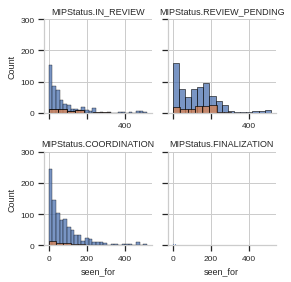

In [25]:
with sns.plotting_context("notebook", font_scale=0.75):
    g = sns.FacetGrid(mip_local_df.loc[~mip_local_df.present], col="status", hue="standard", col_wrap=2, height=2, ylim=(0,300))
    g.map(sns.histplot, "seen_for")
    g.set_titles("{col_name}")
    plt.show()